In [1]:
import gym
import collections
import random
import time
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib.pyplot import *
from IPython.display import clear_output
import time
import csv
from gym import envs
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU, ZeroPadding2D, Input
from keras.layers.convolutional import Conv2D
from keras.layers.recurrent import LSTM, GRU
from keras.models import Sequential, load_model, Model
from keras import regularizers, optimizers
from keras.optimizers import RMSprop, Adam
from keras.models import Sequential, load_model
from keras import regularizers, optimizers
from keras.utils import to_categorical
#np.random.seed(1234)
import scipy.io as sio
import scipy as scp
from scipy import stats
import operator
from keras import backend as K
import tensorflow as tf
import os
import keras
import keras.losses
from keras.models import load_model
from IPython.display import display, clear_output
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]='0'
#config=tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction=0.5
#set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
all_envs = envs.registry.all()
env_ids = [env_spec.id for env_spec in all_envs]
print(np.transpose(env_ids)) 

['Copy-v0' 'RepeatCopy-v0' 'ReversedAddition-v0' 'ReversedAddition3-v0'
 'DuplicatedInput-v0' 'Reverse-v0' 'CartPole-v0' 'CartPole-v1'
 'MountainCar-v0' 'MountainCarContinuous-v0' 'Pendulum-v0' 'Acrobot-v1'
 'LunarLander-v2' 'LunarLanderContinuous-v2' 'BipedalWalker-v2'
 'BipedalWalkerHardcore-v2' 'CarRacing-v0' 'Blackjack-v0'
 'KellyCoinflip-v0' 'KellyCoinflipGeneralized-v0' 'FrozenLake-v0'
 'FrozenLake8x8-v0' 'CliffWalking-v0' 'NChain-v0' 'Roulette-v0' 'Taxi-v2'
 'GuessingGame-v0' 'HotterColder-v0' 'Reacher-v2' 'Pusher-v2' 'Thrower-v2'
 'Striker-v2' 'InvertedPendulum-v2' 'InvertedDoublePendulum-v2'
 'HalfCheetah-v2' 'Hopper-v2' 'Swimmer-v2' 'Walker2d-v2' 'Ant-v2'
 'Humanoid-v2' 'HumanoidStandup-v2' 'FetchSlide-v1' 'FetchPickAndPlace-v1'
 'FetchReach-v1' 'FetchPush-v1' 'HandReach-v0'
 'HandManipulateBlockRotateZ-v0' 'HandManipulateBlockRotateParallel-v0'
 'HandManipulateBlockRotateXYZ-v0' 'HandManipulateBlockFull-v0'
 'HandManipulateBlock-v0' 'HandManipulateEggRotate-v0'
 'HandManipul

In [2]:
# FF
class DQNAgent:
    def __init__(self):
        #(210,160,3),6
        self.drop = 0
        self.state_size = (128,)
        self.action_size = 3 # 9 for pacman, 6 for space invader
        self.memory = collections.deque(maxlen=1000000)
        self.gamma = 0.99    # discount rate 0.95
        self.epsilon = 1  # exploration rate 1 
        self.epsilon_min = 0.05
        self.epsilon_decay = []
        self.learning_rate = []
        self.time_penalty = 0
        self.fix = False       
        self.model = []
        self.target_model = []
        self.target_update_rate = []
        self.optimizer_param = []
        self.frames_played = 0
        self.frames_trained = 0
    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        
        model.add(Dense(128, input_shape=self.state_size, activation='relu'))
        #model.add(Dropout(self.drop))
                
        model.add(Dense(128, activation='relu'))
        #model.add(Dropout(self.drop))
        
        model.add(Dense(128, activation='relu'))
        #model.add(Dropout(self.drop))

        #model.add(Dense(128, activation='relu'))
        #model.add(Dropout(self.drop))
        
        model.add(Dense(self.action_size, activation='linear'))
        
        model.compile(loss=huber_loss, optimizer=self.optimizer_param)        
        #model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        
        model.summary()
        return model
    
    def copy_model(self):
        
        self.target_model.set_weights(self.model.get_weights())
        return []
    

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            act_values = np.zeros((1,self.action_size))
            action = env.action_space.sample()
            while action == 1:
                action = env.action_space.sample()
            return act_values, action
        state = np.expand_dims(state,axis=0)
        #print(state.shape)
        act_values = self.model.predict(state)
        action = np.argmax(act_values)
        if action == 1:
            action = 3
        return act_values,action   # returns action

    def replay(self, batch_size,e):
        minibatch = random.sample(self.memory, batch_size)
        
        if e%self.target_update_rate == 0:
            self.copy_model()
            
        for state, action, reward, next_state, done in minibatch:
            state = np.expand_dims(state,axis=0)
            next_state = np.expand_dims(next_state,axis=0)
            target = 0 #if we are done the final reward is our target
            if not done: #if we are not done the target is the current reward plut the predicted reward from the next state
                
                #Normal Q
                #target = reward + self.gamma * np.amax(self.model.predict(next_state))
                
                #Double Q
                target = reward + self.gamma * np.amax(self.target_model.predict(next_state))

            target_f = self.model.predict(state) 
            #print(target_f)
            target_f[0][action] = target - self.time_penalty
            
            self.model.fit(state, target_f, epochs=1, verbose=0) 
            self.frames_trained = self.frames_trained+1
        if self.fix == False:
            if self.epsilon > self.epsilon_min:
                self.epsilon -= self.epsilon_decay
                
def huber_loss(y_true, y_pred):
    clip_delta=2.0
    error = y_true - y_pred
    cond  = tf.keras.backend.abs(error) < clip_delta

    squared_loss = 0.5 * tf.keras.backend.square(error)
    linear_loss  = clip_delta * (tf.keras.backend.abs(error) - 0.5 * clip_delta)

    return tf.where(cond, squared_loss, linear_loss)
keras.losses.huber_loss = huber_loss

In [9]:
def train_agent(agent,env,episodes,iteration,iterations,fix):
    total_reward_counter = np.empty([episodes])
    Q_reward_counter = np.empty([episodes])
    performance = 0
    
    #agent.epsilon = 1
    for e in range(episodes):
        
        if e > fix: 
            agent.fix = False
        
        total_reward = 0
        state = env.reset()
        state, reward, done, info = env.step(0)
        state = state/256
        i_died = 0
        lives_before = 5
        lives_after = 4
        
        for time_t in range(10000):
            agent.frames_played = agent.frames_played+1
 
            if time_t < (i_died+2):
                next_state, reward, done, info = env.step(1)
                if reward>0:   #should never happen
                    reward = 1
                lives_before = info['ale.lives']
                lives_after = info['ale.lives']
                next_state = next_state/256
            else:
                lives_before = info['ale.lives']
                
                actvals, action = agent.act(state)
                next_state, reward, done, info = env.step(action)
                next_state = next_state/256
                lives_after = info['ale.lives']
                
                if reward>0:
                    reward = 1
                    total_reward = total_reward + reward   
            
                if action == 3: #transform environment action back to agent action
                    action = 1
                
                agent.remember(state, action, reward, next_state, done)
            
            if lives_after<lives_before:
                i_died = time_t
            
            #env.render()
            #time.sleep(0.5)
            state = next_state

            if done:
                clear_output(wait=True)
                print("episode: {}/{}, score: {}, epsilon: {}, frames played: {},frames trained: {},performance: {}".format(e+1, episodes, total_reward, agent.epsilon, agent.frames_played, agent.frames_trained, performance))
                Q_reward_counter[e] = np.max(actvals)
                total_reward_counter[e] = total_reward

                break
        if agent.fix == False:
            agent.replay(32,e)
            if e>1000:
                performance = np.mean(total_reward_counter[(e-900):e])
    return Q_reward_counter, total_reward_counter

In [3]:
#env = gym.make('SpaceInvaders-v0')
env = gym.make('Breakout-ramDeterministic-v4')
balls = np.zeros(1000)
for i in  range(1000):
    balls[i] = env.action_space.sample()
print(np.max(balls)+1)
state = env.reset()
next_state, reward, done, info = env.step(1)
lives_before = info['ale.lives']
print(info)
state.shape

4.0
{'ale.lives': 5}


(128,)

In [10]:
fix = 150
episodes = 100000 # 150.000

iterations = 1

target_update_rate = 300
target_update_rate = np.repeat(target_update_rate,iterations)

learning_rates = [0.0001]#,0.0002,0.0002]
learning_rates = np.repeat(learning_rates,iterations)

decay = [0.00003]#,0.99992,0.99992]   #30.000eps
decay = np.repeat(decay,iterations)

#optim = ['rmsprop','adam','sgd']
optim = ['adam']
optim = np.repeat(optim,iterations)
##################################################################

total_rewards = np.empty([iterations,episodes])
Q_rewards = np.empty([iterations,episodes])

for iteration in range(iterations):
    env = gym.make('Breakout-ramDeterministic-v4')

    agent = DQNAgent()   
    
    agent.fix = True
        
    #Decay parameter
    agent.epsilon_decay = decay[iteration]
    
    agent.learning_rate = learning_rates[iteration]
    agent.target_update_rate = target_update_rate[iteration]
    
    if optim[iteration] == 'rmsprop':
        optimizer_param = optimizers.RMSprop(lr=agent.learning_rate)
        
    if optim[iteration] == 'adam':
        optimizer_param = optimizers.Adam(lr=agent.learning_rate)
        
    if optim[iteration] == 'sgd':
        optimizer_param = optimizers.SGD(lr=agent.learning_rate)
        
    agent.optimizer_param =  optimizer_param 
    
    agent.model = agent._build_model()
    agent.target_model = agent._build_model()
    agent.copy_model()
    #agent.target_model = agent._build_model()
    Q_reward_counter, total_reward_counter = train_agent(agent,env,episodes,iteration,iterations,fix)
    
    total_rewards[iteration][:] = total_reward_counter
    Q_rewards[iteration][:] = Q_reward_counter


episode: 100000/100000, score: 14, epsilon: 0.04999000000062273, frames played: 33597423,frames trained: 3195136,performance: 11.907142857142857


/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sam/samretrogames/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0.5,1,'Q Values')

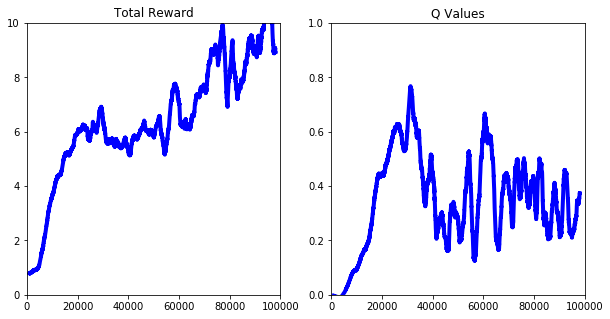

In [11]:
#iterations = 20
plt.figure(figsize=(10,5))
a = subplot(121)
#iterations = 10
iteration_value = optim
window = 1000

total_avg_all = np.empty([iterations,episodes-(window*2)])
#x = np.arange(episodes)
for iteration in range(iterations):
    total_avg = np.zeros([episodes-(window*2)])
    for pnts in range(total_rewards[iteration].shape[0]-(window*2)):
        total_avg[pnts] =  np.mean(total_rewards[iteration][(pnts-window) : pnts+window])

    perf, = plt.plot(np.float32(total_avg),label = iteration_value[iteration])
    total_avg_all[iteration] = total_avg 
#legend()
plt.plot(np.mean(total_avg_all,0),linewidth=4.0,color='b')
plt.axis([0, episodes, 0, 10])
title('Total Reward')
subplot(122)

iteration_value = optim


rew_avg_all = np.empty([iterations,episodes-(window*2)])
#x = np.arange(episodes)
for iteration in range(iterations):
    rew_avg = np.zeros([episodes-(window*2)])
    for pnts in range(Q_rewards[iteration].shape[0]-(window*2)):
        rew_avg[pnts] =  np.mean(Q_rewards[iteration][(pnts-window) : pnts+window])

    perf, = plt.plot(np.float32(rew_avg),label = iteration_value[iteration])
    rew_avg_all[iteration] = rew_avg 
#legend()
plt.plot(np.mean(rew_avg_all,0),linewidth=4.0,color='b')
plt.axis([0, episodes, 0, 1])
title('Q Values')

In [12]:
#np.savetxt('total_reward100k.csv',np.transpose(total_rewards),delimiter=",")
#np.savetxt('Q_reward100k.csv',np.transpose(Q_rewards),delimiter=",")

In [13]:
#agent.model.save('breakoutfeedforwardRAM100ka.h5')

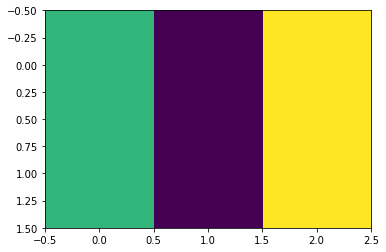

2


In [4]:
#playtest

agent = DQNAgent()
agent.model = keras.models.load_model('breakoutfeedforwardRAM100ka.h5')
agent.epsilon = 0.05
agent.fix = True

i_died = 0
frms = 0
lives_before = 5
lives_after = 4
env = gym.make('Breakout-ramDeterministic-v4')
action = 0


#model = model_from_json(open('breakoutfeedforwardRAM150k.h5').read())
#model.load_weights(os.path.join(os.path.dirname(modelFile), 'model_weights.h5'))

#envisual = gym.make('BreakoutDeterministic-v0')
state = env.reset()
#statevisual = envisual.reset()



plt.ion()
fig = plt.figure()


plt.axis([0, 432, 0, 288])
agent.epsilon = 0;
actgrid = [[0,0,0],[0,0,0]]
actvals = [[0,0,0],[0,0,0]]
tot_rew = 0
#for e in range(10000):
#    state = env.reset()
#statevisual = envisual.reset()
for time_t in range(10000):
    clear_output(wait=True)

    #state = np.expand_dims(state,axis=4)


    state_pred = np.expand_dims(state,axis=0)
    expectation = np.amax(agent.model.predict(state_pred))

    #print(agent.model.predict(np.random.rand(1,128)))

    #actgrid[0][0] = actvals[0][5]
    #actgrid[0][1] = actvals[0][1]
    #actgrid[0][2] = actvals[0][4]

    actgrid[0][0] = actvals[0][1]
    actgrid[0][1] = actvals[0][0]
    actgrid[0][2] = actvals[0][2]

    actgrid[1][0] = actvals[0][1]
    actgrid[1][1] = actvals[0][0]
    actgrid[1][2] = actvals[0][2]

    #actgrid[2][0] = actvals[0][8]
    #actgrid[2][1] = actvals[0][4]
    #actgrid[2][2] = actvals[0][7]

    #action = 3
    
            
    if time_t < (i_died+2):
        next_state, reward, done, info = env.step(1)
        if reward>0:   #should never happen
            reward = 1
        lives_before = info['ale.lives']
        lives_after = info['ale.lives']
        next_state = next_state/256
    else:
        lives_before = info['ale.lives']

        actvals, action = agent.act(state)
        next_state, reward, done, info = env.step(action)
        next_state = next_state/256
        lives_after = info['ale.lives']

        if action == 3: #transform environment action back to agent action
            action = 1

    if lives_after<lives_before:
        i_died = time_t
            
            #env.render()
            #time.sleep(0.5)
    state = next_state
        
    tot_rew = tot_rew+reward

    env.render()

    plt.imshow(actgrid,vmin = np.min(actgrid), vmax = np.max(actgrid))


    plt.show()
    print(action)
    #print(expectation)
    #print(lives_before)
    #print(tot_rew)
    #print(frms)
    #print(reward2)
    #time.sleep(0.05)
    #print(action)


    frms = frms+1

    if done:
        env.close()
        break
        

In [11]:
#agent.model.save('breakoutfeedforwardRAM10k.h5')